In [81]:
import pandas as pd
#import pandas_datareader as pdr
import requests
import eurostat
import pyreadr

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload


from helper import (get_regions, currency_country_map, eu)

In [61]:
import helper
reload(helper)
from helper import (currency_country_map)

### EU-KLEMS: More detailed analysis - getting absolute values of ULC
#### Goal: get ULC by own calculation and also on a sectoral level
#### variables description: https://www.dropbox.com/s/ziu7wpl8pgqhq51/Variable%20List.xlsx?dl=0
#### KLEMS main website: https://euklems.eu/query/
#### The 2019 KLEMS release: https://euklems-intanprod-llee.luiss.it/download/
#### New KLEMS seems to refer to Nama_10_a64 : https://euklems.eu/wp-content/uploads/2023/01/wiiw-GPD_Release2023.pdf

In [62]:
# old version of KLEMS (not sure which one but it ends in 2019, so I call it 2019)
# NOTE: here for rerefence and checking, but not actively used
klems_na = pyreadr.read_r("national accounts.rds")[None]
klems_na = klems_na.astype({"year": int})
klems_na = get_regions(klems_na, 'geo_code')

klems_na.head()

,nace_r2_code,geo_code,nace_r2_name,geo_name,year,COMP,EMP,EMPE,GO_CP,GO_PI,...,H_EMPE,II_CP,II_PI,II_PYP,II_Q,VA_CP,VA_PI,VA_PYP,VA_Q,region
0,A,AT,"Agriculture, forestry and fishing",Austria,1995,363.7,273.10,20.59,7656.1,92.326044,...,39192.0,3843.9,74.985756,4168.299699,5126.173576,3812.3,116.708,3917.4,3266.528430,DE_AT
1,A,AT,"Agriculture, forestry and fishing",Austria,1996,369.6,260.92,20.40,7485.4,89.203056,...,38589.0,3866.6,73.638100,3937.362930,5250.814488,3618.8,110.849,3810.1,3264.621242,DE_AT
2,A,AT,"Agriculture, forestry and fishing",Austria,1997,380.5,254.58,20.88,7632.7,89.326044,...,39008.0,4036.6,74.460979,3991.990935,5421.094460,3596.1,109.807,3630.2,3274.927828,DE_AT
3,A,AT,"Agriculture, forestry and fishing",Austria,1998,382.0,244.97,20.28,7414.2,85.778455,...,38325.0,3893.0,73.579585,3939.633414,5290.869760,3521.2,102.255,3781.2,3443.547993,DE_AT
4,A,AT,"Agriculture, forestry and fishing",Austria,1999,398.4,240.43,20.74,7385.2,83.380806,...,39831.0,3874.4,73.007411,3904.764431,5306.858477,3510.8,97.215,3692.8,3611.376845,DE_AT


### Getting Eurostat data

- Original loads - DO NOT RUN

In [ ]:
## Downloading the data from Eurostat - this is due to the changes in the most recent KLEMS format
## The values for the relevant variables are the same as from the EU-KLEMS data above, but containing 2019-2022 data.
## First I get the Value added 
# NOTE: downloaded and save below on Dec 13, 2023, NO NEED TO RUN IT AGAIN!
nama_a10_a64 = eurostat.get_data_df("nama_10_a64").rename(columns={"geo\\time": "Country"})
nama_a10_a64 = nama_a10_a64.loc[np.where((
                                      (nama_a10_a64['unit'] == "CP_MNAC") &
                                      (nama_a10_a64['na_item'].isin(["B1G", "D1"])) # BG1 = Value added (Gross), D1 = employee compensation
                                      ))]
nama_a10_a64.columns = nama_a10_a64.columns.astype(str) # turning the year-columns into strings

# Data from query above saved as csv on 14-12-20
nama_a10_a64.to_csv('nama_10_a10_a64.csv') 

- Value added and Labor compensation - csv load

In [91]:
# Start here - loading the data
nama_10_a10_a64_csv = pd.read_csv('nama_10_a10_a64.csv', index_col=0).rename(columns={'Country': "country_code"})

nama_10_a10_a64_va_cp = nama_10_a10_a64_csv[nama_10_a10_a64_csv['na_item'] == "B1G"].melt(['country_code', 'nace_r2'], value_vars = [str(i) for i in range(1995, 2022)] , var_name = 'year', value_name = 'VA_CP')
nama_10_a10_a64_comp = nama_10_a10_a64_csv[nama_10_a10_a64_csv['na_item'] == "D1"].melt(['country_code', 'nace_r2'], value_vars = [str(i) for i in range(1995, 2022)] , var_name = 'year', value_name = 'COMP')

nama_df = nama_10_a10_a64_va_cp.merge(nama_10_a10_a64_comp, on=['country_code', 'nace_r2', 'year'])
nama_df['year'] = nama_df['year'].astype(int)
nama_df.head()

,country_code,nace_r2,year,VA_CP,COMP
0,AT,A,1995,3812.3,363.7
1,BA,A,1995,NaN,NaN
2,BE,A,1995,2750.3,203.7
3,BG,A,1995,117.6,12.5
4,CH,A,1995,5836.1,NaN


In [74]:
#### Additional Variables - deflators and PPPs, WB data originally used in CEE_competitiveness.ipynb
#- World bank GDP deflator: NY.GDP.DEFL.ZS (NY.GDP.DEFL.ZS.AD), NY.GDP.DEFL.KD.ZG.AD
#- or get VA deflator using NV.IND.MANF.KD, NV.IND.MANF.KN (see Golub et al., 2018)

#Note that WB data does not cover Eurozone as an entity!!!!

##### Additional Variables: 
- prc_ppp_ind for PPP 
- ert_bil_eur_a for nominal FX (note that I may not need it directly but should be useful for decomposition)
- namq_10_gdp (for GDP deflator)


- Additional variables - Original Loads DO NOT RUN

In [ ]:
# Eurostat documentation: "PPPs can be interpreted as the exchange rates of countries' national currencies against the PPS. They express the number of currency units per PPS.""
prc_ppp_ind_ = eurostat.get_data_df("prc_ppp_ind").rename(columns={"geo\TIME_PERIOD": "country_code"})
prc_ppp_ind_ = prc_ppp_ind_.loc[np.where((
                                      (prc_ppp_ind_['ppp_cat'] == "GDP") & #TODO: Totally double check!!!!
                                      (prc_ppp_ind_['na_item'] == "PPP_EU27_2020")
                                      ))]
prc_ppp_ind_.columns = prc_ppp_ind_.columns.astype(str) # turning the year-columns into strings
prc_ppp_ind_ = prc_ppp_ind_.melt(['country_code', 'na_item', 'ppp_cat'], value_vars = [str(i) for i in range(1995, 2022)] , var_name = 'year', value_name = 'PPP')

prc_ppp_ind_.to_csv('prc_ppp_ind.csv') # Downloaded on Jan 28, 2024, DO NOT RUN!
prc_ppp_ind_.head()

In [ ]:
# Deflator is obtained from the same DB as the original VA and COMP data.
nama_a10_deflator = eurostat.get_data_df("nama_10_a64").rename(columns={"geo\\TIME_PERIOD": "country_code"})
nama_a10_deflator = nama_a10_deflator.loc[np.where((
                                      (nama_a10_deflator['unit'] == "PD15_NAC") &
                                      (nama_a10_deflator['na_item'].isin(["B1G"])) # BG1 = Value added (Gross)
                                      ))]
nama_a10_deflator.columns = nama_a10_deflator.columns.astype(str) # turning the year-columns into strings
nama_a10_deflator = nama_a10_deflator.melt(['country_code', 'na_item', 'nace_r2', 'unit'], value_vars = [str(i) for i in range(1995, 2022)] , var_name = 'year', value_name = 'Deflator')
nama_a10_deflator.to_csv('nama_a10_deflator.csv') # Downloaded on Jan 28, 2024, DO NOT RUN!
nama_a10_deflator.head()

In [ ]:
# TODO: Note that VA and COMP variables could be obtained as EUR values directly from nama_10_a64, consider doing so
ert_bil_eur_a = eurostat.get_data_df("ert_bil_eur_a").rename(columns={"currency\\TIME_PERIOD": "currency"})
ert_bil_eur_a = ert_bil_eur_a.loc[np.where((
                                  (ert_bil_eur_a['statinfo'] == "AVG")# NOTE: check, could be important!
                                  ))]
ert_bil_eur_a.columns = ert_bil_eur_a.columns.astype(str) # turning the year-columns into strings
ert_bil_eur_a = ert_bil_eur_a.melt(['unit', 'currency'], value_vars = [str(i) for i in range(1995, 2022)] , var_name = 'year', value_name = 'ER')
ert_bil_eur_a['country_code'] = [currency_country_map[cur] if cur in currency_country_map else np.nan for cur in ert_bil_eur_a['currency']]
ert_bil_eur_a = ert_bil_eur_a[ert_bil_eur_a['country_code'].notna()]

ert_bil_eur_a.to_csv('ert_bil_eur_a.csv') # Downloaded on Feb 3, 2024, DO NOT RUN!

ert_bil_eur_a

- Additional variables CSV loads

In [75]:
# Start here - loading the data
prc_ppp_ind = pd.read_csv('prc_ppp_ind.csv', index_col=0)
prc_ppp_ind.head()

,country_code,na_item,ppp_cat,year,PPP
0,AL,PPP_EU27_2020,GDP,1995,NaN
1,AT,PPP_EU27_2020,GDP,1995,1.119540
2,BA,PPP_EU27_2020,GDP,1995,NaN
3,BE,PPP_EU27_2020,GDP,1995,1.104520
4,BG,PPP_EU27_2020,GDP,1995,0.023401


In [76]:
# NOTE we need (EA11-1999, EA12-2001, EA13-2007, EA15-2008, EA16-2009, EA17-2011, EA18-2014, EA19-2015, EA20-2023) = EA) to be able to join this to nama_10_a64 dfs
def get_ea(x):
    yr = x['year'].unique()[0]
    ea_row = {'country_code': 'EA', 'na_item': 'PPP_EU27_2020', 'ppp_cat': 'GDP', 'year': yr}
    v = 'EA11'
    if yr >= 2023: 
        v = 'EA20'
    elif yr > 2015:
        v = 'EA19'
    elif yr == 2014:
        v='EA18'
    elif yr >= 2011:
        v='EA17'
    elif yr >= 2009:
        v='EA16'
    elif yr == 2008:
        v='EA15'
    elif yr == 2007:
        v='EA13'
    elif yr >= 2001:
        v='EA12'

    ea_row['PPP'] = x.loc[lambda i: i['country_code'] == v, 'PPP'].values[0]
    x = x.append(ea_row, ignore_index=True)
    return x


prc_ppp_ea = prc_ppp_ind[prc_ppp_ind['country_code'].str.contains('EA')].groupby('year', as_index=False).apply(lambda x: get_ea(x)).reset_index(drop=True)
prc_ppp_ea = prc_ppp_ea[prc_ppp_ea['country_code'] == 'EA']

prc_ppp_ind = prc_ppp_ind.append(prc_ppp_ea)


In [77]:
# Start here - loading the data
nama_a10_deflator = pd.read_csv('nama_a10_deflator.csv', index_col=0)
nama_a10_deflator.head()

,country_code,na_item,nace_r2,unit,year,Deflator
0,AL,B1G,A,PD15_NAC,1995,56.233
1,AT,B1G,A,PD15_NAC,1995,116.708
2,BE,B1G,A,PD15_NAC,1995,134.423
3,BG,B1G,A,PD15_NAC,1995,2.323
4,CH,B1G,A,PD15_NAC,1995,138.368


In [78]:
# Start here - loading the data
ert_bil_eur_a = pd.read_csv('ert_bil_eur_a.csv', index_col=0)
ert_bil_eur_a.head()

,unit,currency,year,ER,country_code
13,NAC,BGN,1995,0.08790,BG
34,NAC,CZK,1995,34.69600,CZ
36,NAC,DKK,1995,7.32800,DK
44,NAC,GBP,1995,0.82879,UK
55,NAC,HUF,1995,164.55000,HU


In [79]:
# test
len(ert_bil_eur_a.loc[ert_bil_eur_a['country_code'].notna(), 'country_code'].unique()) == len(currency_country_map)

True

### Finalizing the ULC

In [93]:
# filtering only EU + selected countries
eu_plus = {'EA': 'Eurozone', 'UK': 'United Kingdom', **eu}
nama_df = nama_df[nama_df['country_code'].isin(eu_plus)]
# Joining additional data sources
nama_df = nama_df.merge(prc_ppp_ind, on=['country_code', 'year'])
nama_df = nama_df.merge(nama_a10_deflator, on=['country_code', 'year', 'nace_r2'], suffixes=['_ppp', '_deflator'])
nama_df = nama_df.merge(ert_bil_eur_a, on=['country_code', 'year'], how='left')
nama_df.loc[nama_df['currency'].isna(), ['currency', 'ER']] = ('EUR', 1)
nama_df.head()

,country_code,nace_r2,year,VA_CP,COMP,na_item_ppp,ppp_cat,PPP,na_item_deflator,unit_x,Deflator,unit_y,currency,ER
0,AT,A,1995,3812.3,363.7,PPP_EU27_2020,GDP,1.11954,B1G,PD15_NAC,116.708,NaN,EUR,1.0
1,AT,A01,1995,2933.0,188.2,PPP_EU27_2020,GDP,1.11954,B1G,PD15_NAC,133.162,NaN,EUR,1.0
2,AT,A02,1995,873.7,174.8,PPP_EU27_2020,GDP,1.11954,B1G,PD15_NAC,80.472,NaN,EUR,1.0
3,AT,A03,1995,5.5,0.7,PPP_EU27_2020,GDP,1.11954,B1G,PD15_NAC,26.776,NaN,EUR,1.0
4,AT,B,1995,543.5,332.1,PPP_EU27_2020,GDP,1.11954,B1G,PD15_NAC,68.418,NaN,EUR,1.0


In [94]:
# Dustmann (2014): Figure 1 notes: unit labor cost for country i in period t, computed as the total wage bill (w_it*L_it)) divided by the value added of the country’s industry
nama_df['VA_real'] = (nama_df['VA_CP'] / nama_df['Deflator']) / nama_df['PPP']
nama_df['W_usd'] = nama_df['COMP'] / nama_df['ER']
ulc_df = nama_df.loc[(nama_df['nace_r2'].isin(['C', 'TOT']))].assign(ULC = lambda x: x['W_usd'] / x['VA_real']) # TODO: check if correct, is it nominal, Piton uses market sector?
#ulc_df = ulc_df.assign(productivity = lambda x: x['VA_real'] / x['H_EMP']) # TODO: check Schröder (2020)  see footnote 14 - should be put to real values
ulc_df['log_ULC'] = np.log(ulc_df['ULC'])
ulc_df['ĺog_diff_ulc'] = np.log(ulc_df['ULC']).diff()
ulc_df.head()

,country_code,nace_r2,year,VA_CP,COMP,na_item_ppp,ppp_cat,PPP,na_item_deflator,unit_x,Deflator,unit_y,currency,ER,VA_real,W_usd,ULC,log_ULC,ĺog_diff_ulc
6,AT,C,1995,31623.4,20214.4,PPP_EU27_2020,GDP,1.119540,B1G,PD15_NAC,87.863,NaN,EUR,1.0000,321.486632,20214.400000,62.877887,4.141195,NaN
96,BE,C,1995,38595.9,24553.5,PPP_EU27_2020,GDP,1.104520,B1G,PD15_NAC,97.654,NaN,EUR,1.0000,357.830661,24553.500000,68.617653,4.228550,0.087355
186,BG,C,1995,126.3,84.4,PPP_EU27_2020,GDP,0.023401,B1G,PD15_NAC,2.295,NAC,BGN,0.0879,2351.713370,960.182025,0.408290,-0.895777,-5.124326
275,CY,C,1995,732.3,281.4,PPP_EU27_2020,GDP,0.823896,B1G,PD15_NAC,66.663,NaN,EUR,1.0000,13.333120,281.400000,21.105338,3.049526,3.945303
365,CZ,C,1995,344159.0,166019.0,PPP_EU27_2020,GDP,13.316200,B1G,PD15_NAC,88.275,NAC,CZK,34.6960,292.779790,4784.960802,16.343207,2.793812,-0.255714


### Relative ULC

In [95]:
# Euro Area: `nama_10_a64` uses EA defined as (Euro area (EA11-1999, EA12-2001, EA13-2007, EA15-2008, EA16-2009, EA17-2011, EA18-2014, EA19-2015, EA20-2023) = EA) vs. `prc_ppp_ind` has all the categories only separately
ulc_ea = ulc_df.loc[(ulc_df['country_code'] == 'EA')]
rulc = ulc_df.merge(ulc_ea, on=['year', 'nace_r2'], suffixes=['', '_ea'])
rulc = rulc[['country_code', 'nace_r2', 'year', 'log_ULC', 'log_ULC_ea']]
rulc['rulc'] = rulc['log_ULC'] - rulc['log_ULC_ea']
# TODO: index the ULC (see Fig.1 in Piton)
rulc

,country_code,nace_r2,year,log_ULC,log_ULC_ea,rulc
0,AT,C,1995,4.141195,4.078577,0.062617
1,BE,C,1995,4.228550,4.078577,0.149972
2,BG,C,1995,-0.895777,4.078577,-4.974354
3,CY,C,1995,3.049526,4.078577,-1.029051
4,CZ,C,1995,2.793812,4.078577,-1.284765
...,...,...,...,...,...,...
751,RO,C,2021,3.246491,4.077964,-0.831473
752,SE,C,2021,4.123901,4.077964,0.045937
753,SI,C,2021,3.965332,4.077964,-0.112632
754,SK,C,2021,3.752557,4.077964,-0.325407


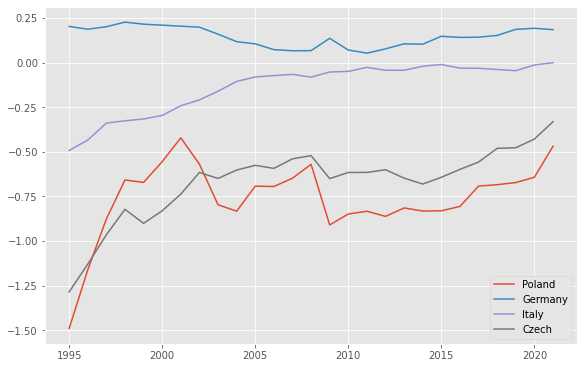

In [96]:
rulc_plot = rulc.groupby('country_code')

with plt.style.context('ggplot'):
    fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 5))
    ax.plot(rulc_plot.get_group('PL')['year'], rulc_plot.get_group('PL')['rulc'], label='Poland')
    ax.plot(rulc_plot.get_group('DE')['year'], rulc_plot.get_group('DE')['rulc'], label='Germany')
    ax.plot(rulc_plot.get_group('IT')['year'], rulc_plot.get_group('IT')['rulc'], label='Italy')
    ax.plot(rulc_plot.get_group('CZ')['year'], rulc_plot.get_group('CZ')['rulc'], label='Czech')

    ax.legend()

### Decomposition

### TODOs

- Check data sources compare with lit.
- Double check calculation
- Create t
- Data downloads to a separate file
- Filter the countries (note that `country_code` assignment for ert_bil_eur_a could create distortin otherwise, all countries apart from the list are marked as EA)